In [1]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn
import torch
from corner import corner
from matplotlib import pyplot as plt

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy
from clipppy.utils import torch_get_default_device


seaborn.reset_orig()
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

/usr/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.0.5-build-libtorrent-rasterbar-src-libtorrent-rasterbar-2.0.5-bindings-python is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
from libsimplesn import SimpleSN

simplesn = SimpleSN(survey='pantheon-g10', datatype='specz', N=10_000, suffix=0, version=0)
config = simplesn.config('simplesn-marginal.yaml', gen=False)
defs = config.kwargs['defs']
truths = torch.load(simplesn.data_name, map_location=torch_get_default_device())

## Run MCMC

In [3]:
from clipppy.utils import to_tensor
from clipppy.commands.emcee import Emcee


mc = Emcee(config, 50, exclude=('z',))
_initial_state = {
    key: to_tensor(val['value']).expand(mc.nwalkers)
    for key, val in config.mock(
        conditioning=True, initting=True, plate_stack=[mc.nwalkers]
    ).nodes.items()
    if key in mc.param_sites
}
initial_state = np.random.normal(pd.DataFrame(mc.deconstrain(_initial_state)).to_numpy(), 0.2)

/home/kosio/Projects/Python/phytorch/phytorch/math.py:29: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/kosio/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /build/python-pytorch/src/pytorch-1.11.0-cuda/aten/src/ATen/native/cuda/jit_utils.cpp:858.)
  return torch.sinc(x)


In [4]:
mc.run_mcmc(initial_state, 1000, progress=True);

100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


State([[-1.85784126e+00 -7.42786367e-01 -1.80570346e+00  1.22206169e+00
   2.48268685e-03  4.05344582e-02 -1.45315799e-02 -2.23394475e+00
  -4.44096581e-02 -5.28918479e-02]
 [-1.72135195e+00 -6.18129522e-01 -1.83034392e+00  1.22163836e+00
  -5.51762628e-03  2.63250447e-03  1.26277374e-02 -2.19345149e+00
   2.01675132e-02  2.70558810e-02]
 [-1.84185691e+00 -7.03876654e-01 -1.82292726e+00  1.23938551e+00
   6.34430344e-03 -4.99301679e-02 -3.30858113e-02 -2.18231269e+00
   2.52337677e-02 -9.83643224e-02]
 [-1.86131032e+00 -7.27845429e-01 -1.82911410e+00  1.18602811e+00
   4.01378540e-03 -1.38936997e-02  1.45748990e-02 -2.18627461e+00
  -1.73379338e-02  5.49683452e-02]
 [-1.80387602e+00 -7.00944123e-01 -1.81472143e+00  1.18557159e+00
   3.48664214e-03 -3.69642904e-03 -3.84993677e-02 -2.20604382e+00
  -7.12110566e-02 -3.64850651e-02]
 [-1.71495103e+00 -5.99841127e-01 -1.79328244e+00  1.16583860e+00
  -1.50815067e-02  3.27954387e-02  2.17063166e-02 -2.20659938e+00
  -1.88585619e-02  2.735240

In [5]:
simplesn.emcee_result = mc

In [3]:
mc = simplesn.emcee_result

In [5]:
idata = mc.to_dataset()

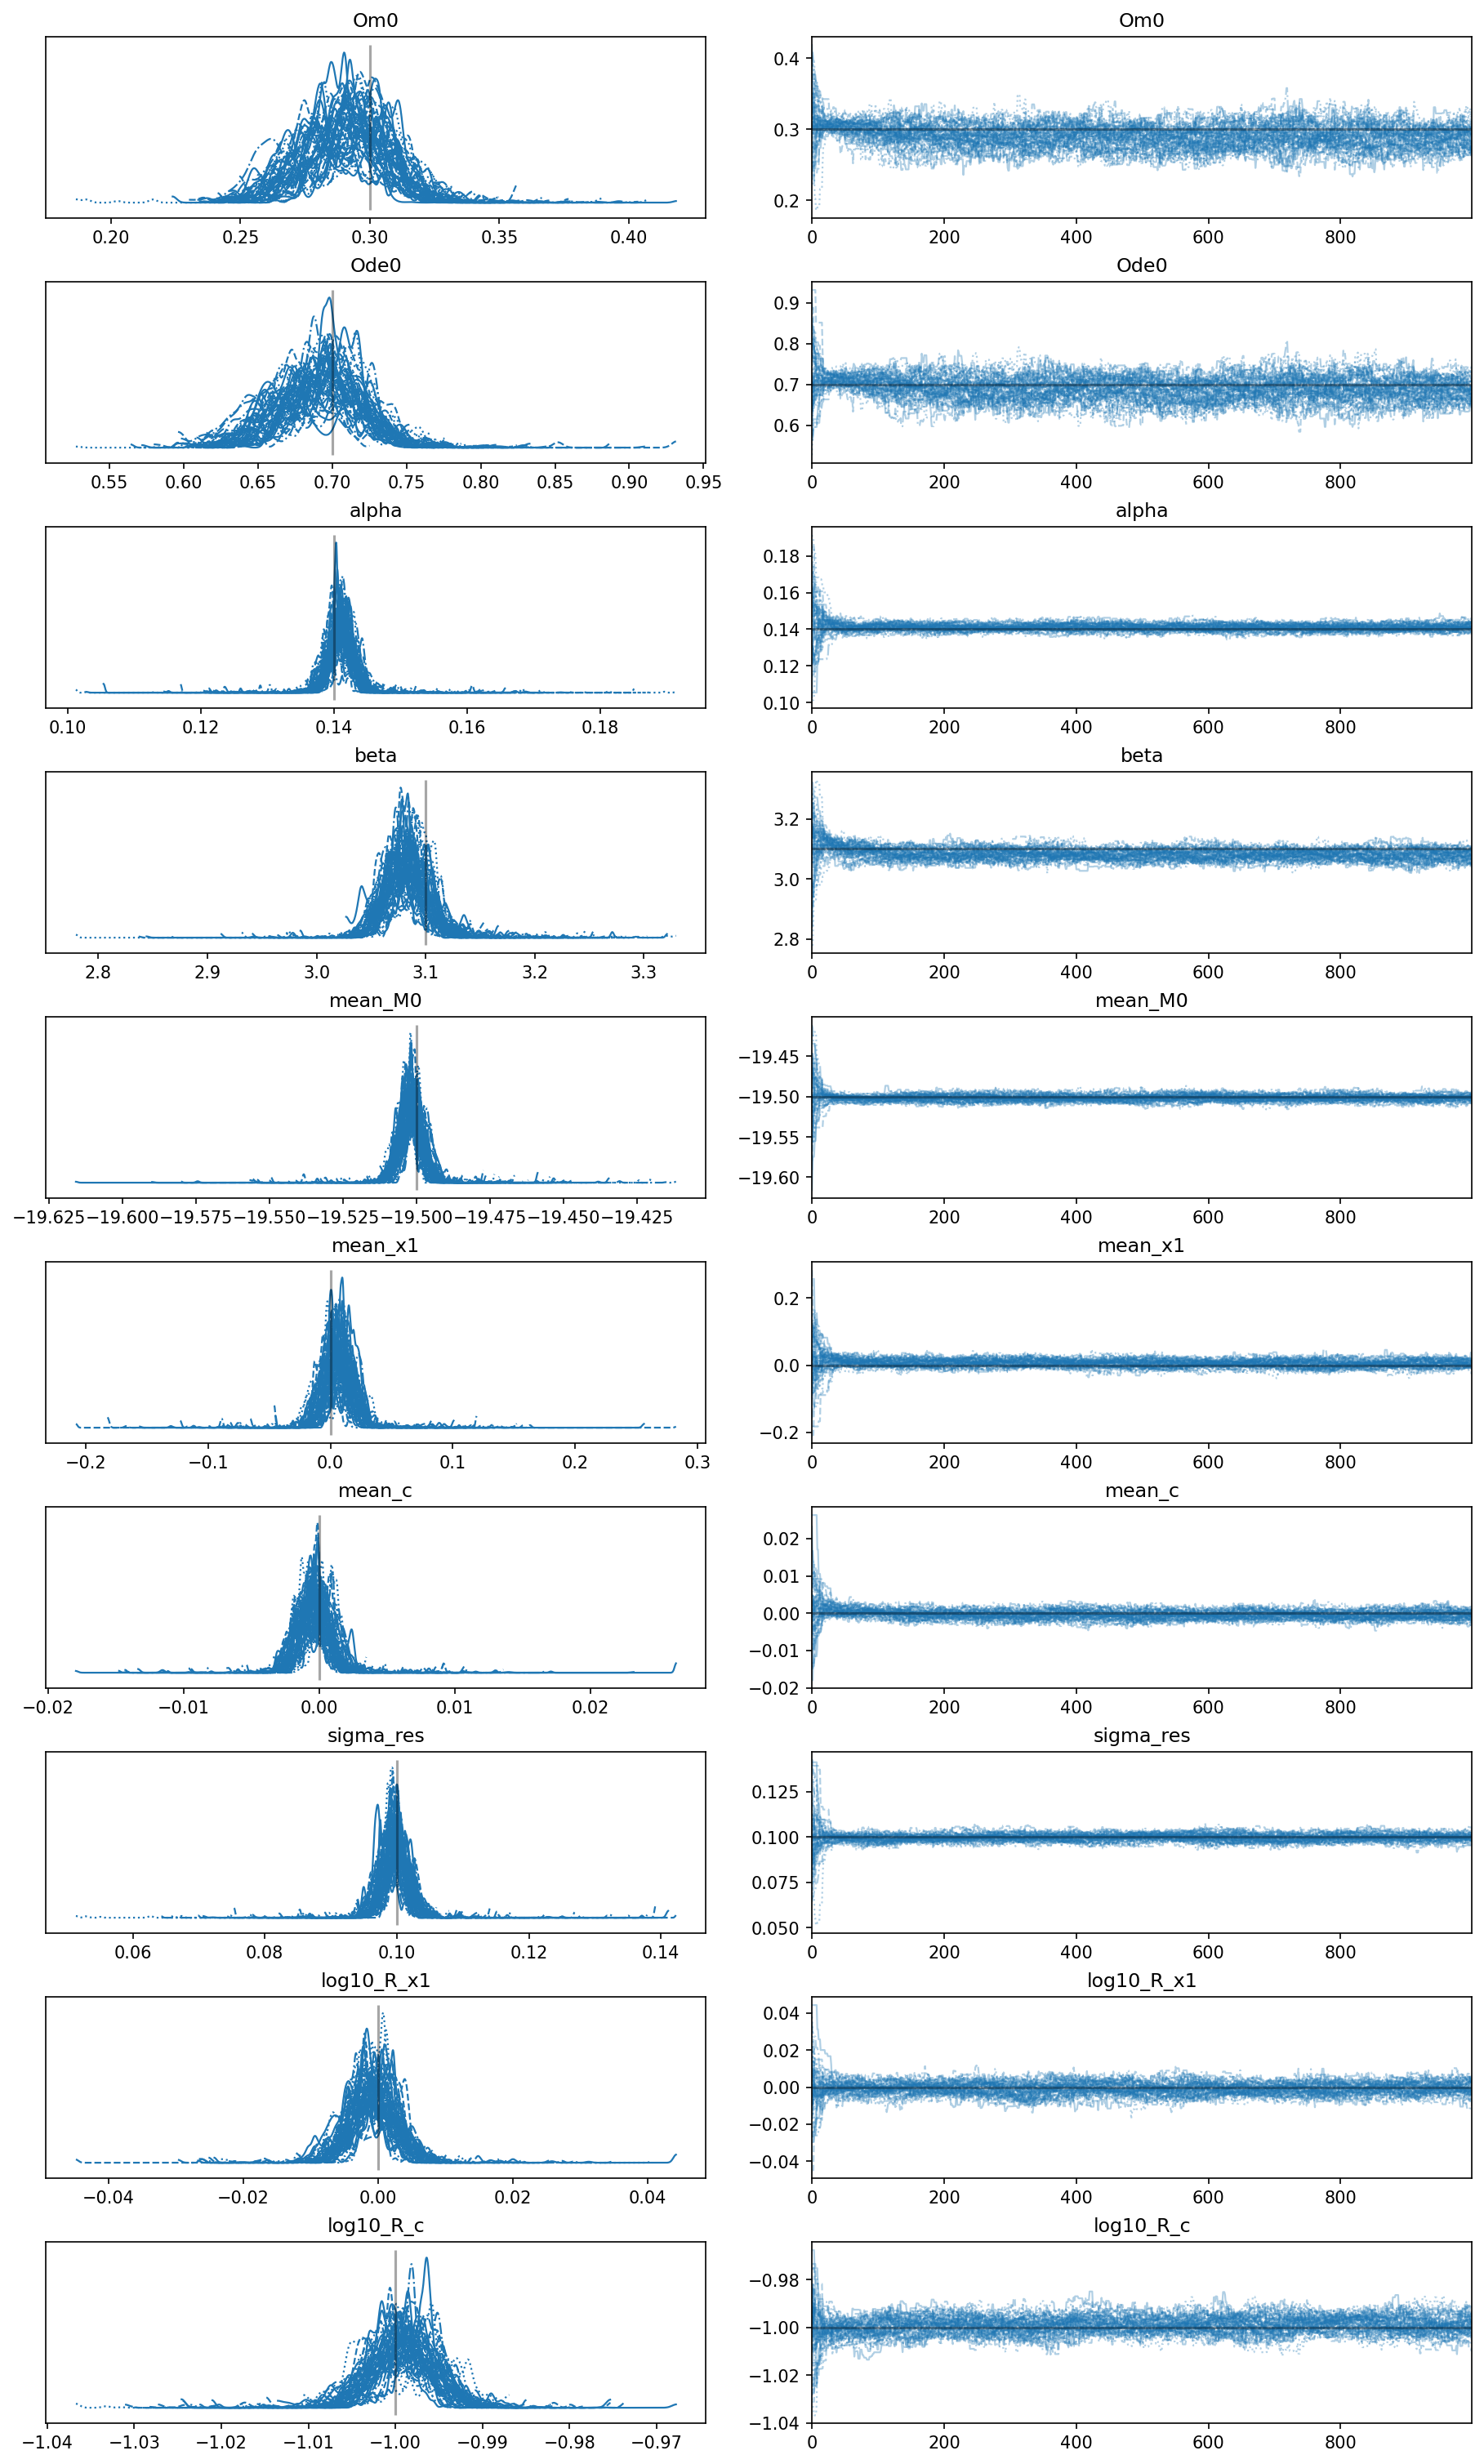

In [6]:
az.plot_trace(idata, lines=[(key, {}, (float(truths[key]),)) for key in idata.keys()], coords={'draw': slice(0, None)});

/usr/lib/python3.10/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


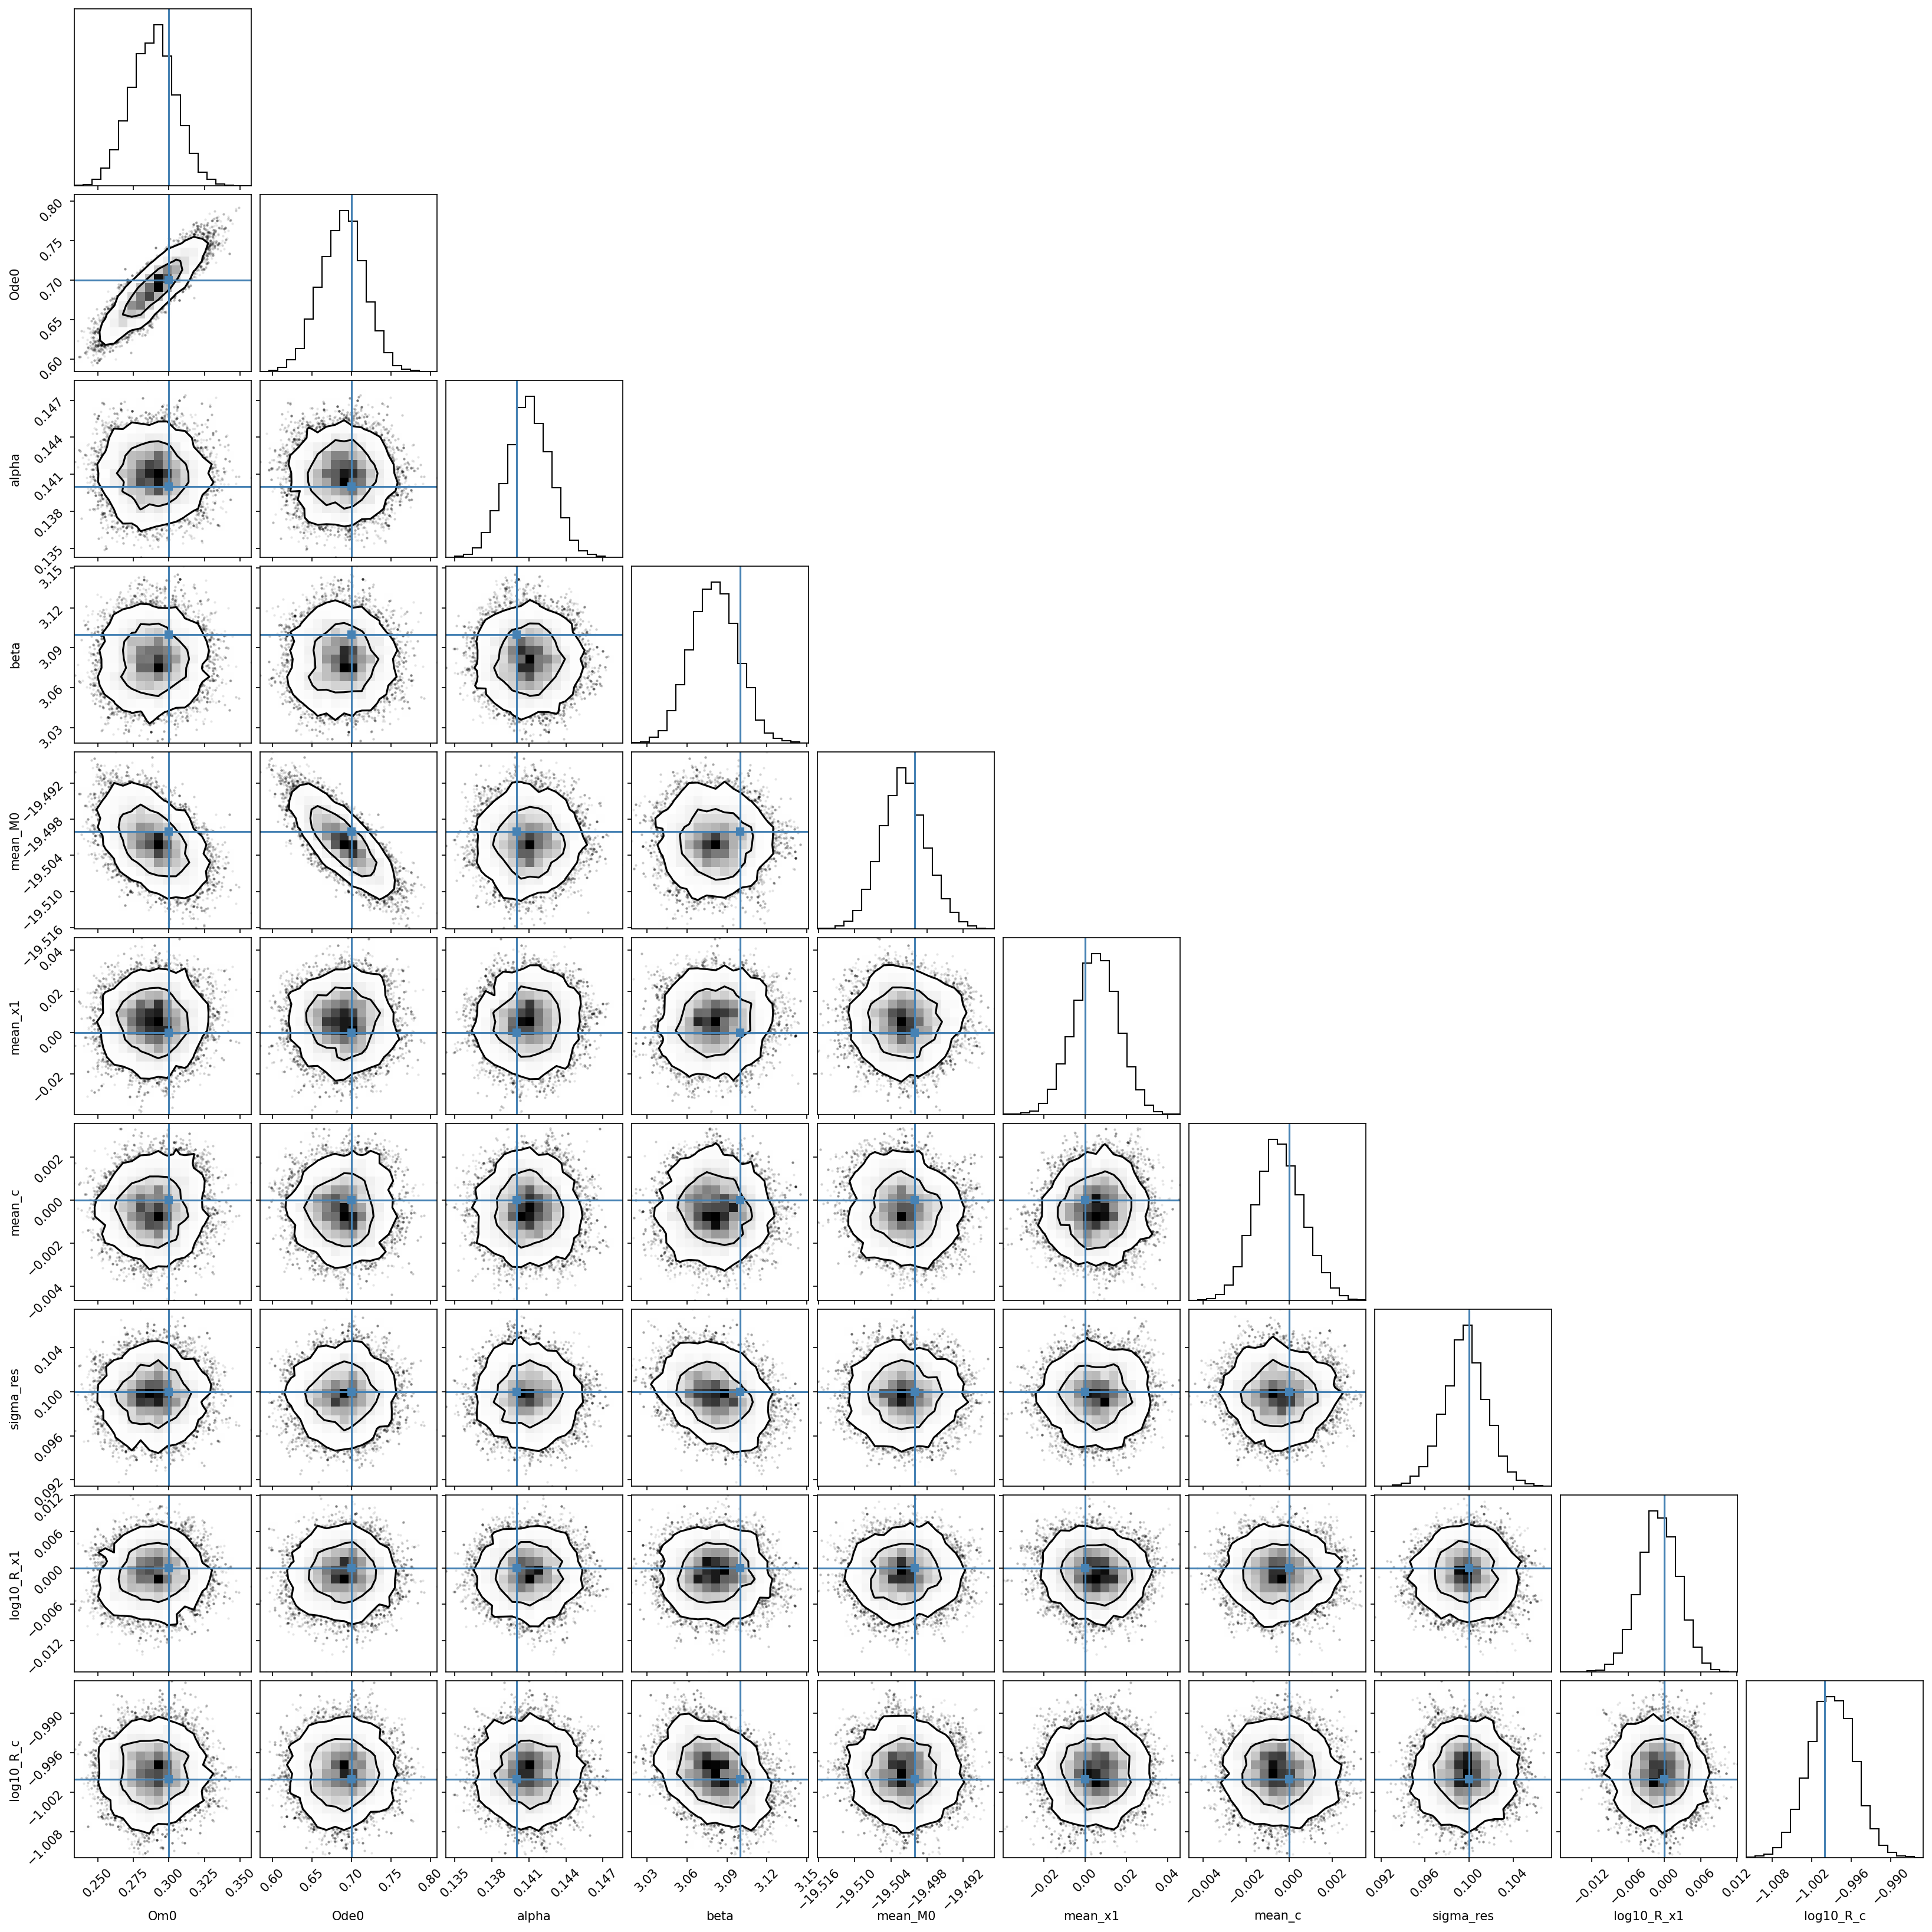

In [7]:
corner(idata[{'draw': slice(200, None)}], levels=(0.68, 0.95), truths=truths);